In [1]:
import sys
import os
os.chdir("..")

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))

In [2]:
import pandas as pd
from src.modeling import preprocess_data
from src.modeling import train_models
from src.evaluation import evaluate_models

# Load data
X_train, X_test, y_train, y_test = preprocess_data.load_modeling_data()

In [7]:
from sklearn.preprocessing import StandardScaler

# Scale data for MLP model only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
rf_model = train_models.train_random_forest(X_train, y_train)
xgb_model = train_models.train_xgboost(X_train, y_train)
lgb_model = train_models.train_lightgbm(X_train, y_train)
mlp_model = train_models.train_mlp(pd.DataFrame(X_train_scaled), y_train)

# Store models with corresponding test inputs
model_inputs = {
    "Random Forest": (rf_model, X_test),
    "XGBoost": (xgb_model, X_test),
    "LightGBM": (lgb_model, X_test),
    "MLP": (mlp_model, X_test_scaled),
}

# Evaluate models
results = []
for name, (model, X_eval) in model_inputs.items():
    y_pred = model.predict(X_eval)
    metrics = evaluate_models.evaluate_regression_model(y_test, y_pred)
    metrics["Model"] = name
    results.append(metrics)

# Display results
results_df = pd.DataFrame(results).set_index("Model")
display(results_df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1489
[LightGBM] [Info] Number of data points in the train set: 3866, number of used features: 6
[LightGBM] [Info] Start training from score 7.029097


,MAE,RMSE,R2
Model,,,
Random Forest,0.673644,0.911084,0.532543
XGBoost,0.690668,0.928647,0.514347
LightGBM,0.669790,0.909999,0.533656
MLP,0.653616,0.884525,0.559400


## Feature Importance Analysis

To better understand which features drive CLV predictions, we extracted feature importances from three tree-based models.

Across Random Forest, XGBoost, and LightGBM, the most important features are typically:

- **Monetary**
- **Frequency**
- **Average Purchase Value**

These features directly describe user spending and behavior. Recency and MeanDaysBetweenPurchases showed variable importance depending on the model, indicating their influence may be more context-dependent.

Such analysis helps us interpret model behavior and validate our feature engineering decisions.


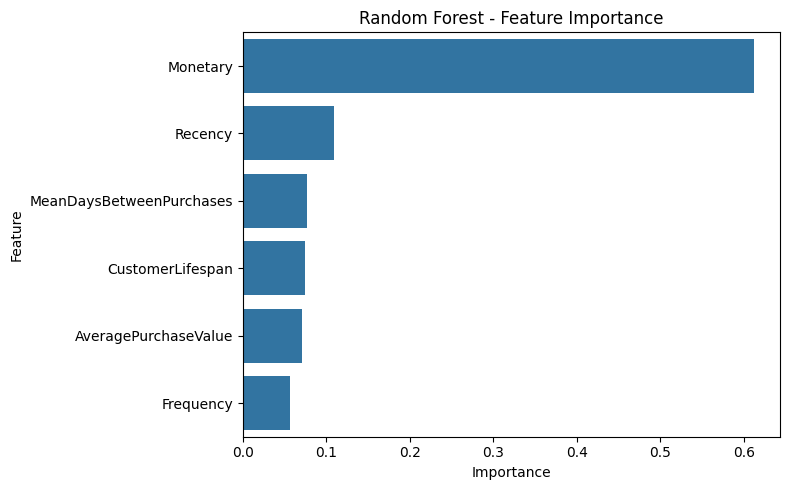

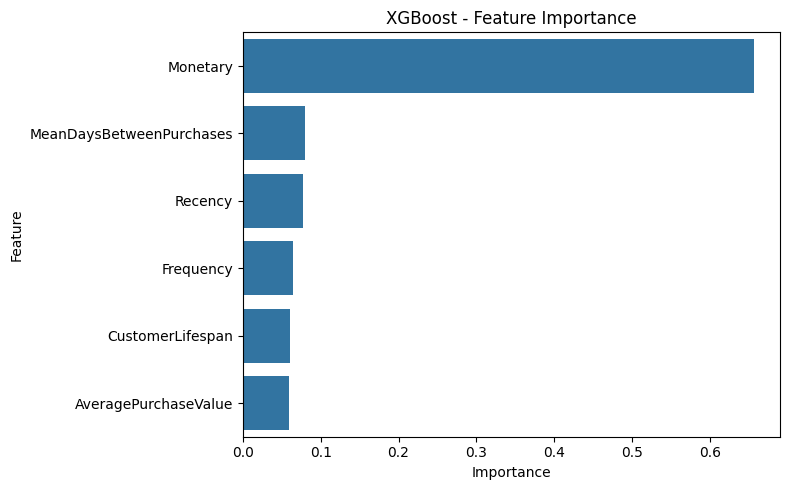

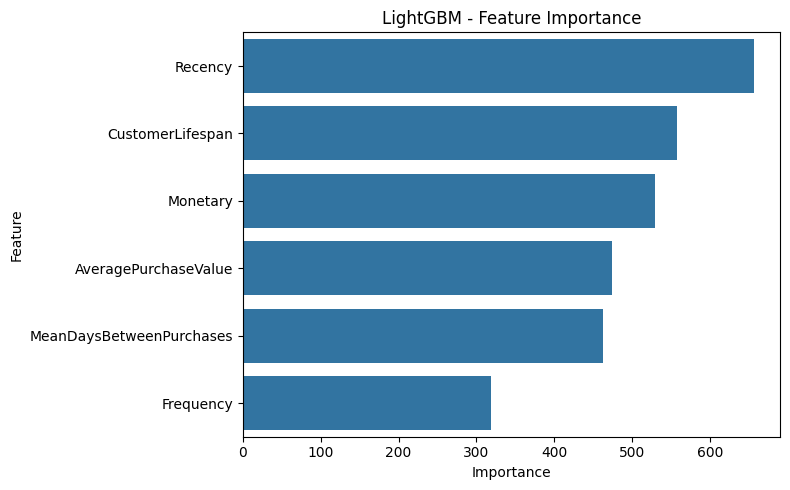

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, X_train, model_name):
    """
    Plot feature importance for tree-based models.
    """
    importances = model.feature_importances_
    feature_names = X_train.columns

    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df.sort_values(by='Importance', ascending=False, inplace=True)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=importance_df, x='Importance', y='Feature')
    plt.title(f'{model_name} - Feature Importance')
    plt.tight_layout()
    plt.show()

# Plot for each tree-based model
plot_feature_importance(rf_model, X_train, "Random Forest")
plot_feature_importance(xgb_model, X_train, "XGBoost")
plot_feature_importance(lgb_model, X_train, "LightGBM")
